# Stereo Correspondences

*   Akshay Bankar (2019201011)

In [4]:
!pip3 install opencv-contrib-python==3.3.0.9

     |████████████████████████████████| 14.8MB 197kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [0]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob
import os
from math import floor
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

## Intensity Window-based correlation 
The functions perform intensity based correlation as follows:
*   Extract patch of 128x128 size for intensity matching
*   Match the patch from one image with other image using OpenCV's matchtemplate(). The function finds correlation using squared-norm method.
*   Draw the obtained matches on the concatenated image





In [0]:
def normalize(x):
    x = np.array(x)
    x_min = np.min(x)
    x_max = np.max(x)
    x_range = x_max - x_min
    x -= x_min
    if (x_range > 0):
        if (x_range < 1):
            return x
        else:
            x = x.astype(float)
            x /= x_range
    return x

def splitImage(image):
    width = image.shape[1]
    image_left = image[:, :floor(width / 2)]
    image_right = image[:, floor(width / 2):]
    return image_left, image_right

def match(image, template, window = 128, method = cv.TM_CCORR_NORMED):
    res = cv.matchTemplate(image, template, method)
    h, w, _ = template.shape
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    center = (top_left[0] + floor(window / 2),
              top_left[1] + floor(window / 2))
    return center

def find_center(top, bottom):
    t = (top[0] + bottom[0]) / 2
    b = (top[1] + bottom[1]) / 2
    return (floor(t), floor(b))

def intensity_based_matching (image1, image2, window = 128, method = cv.TM_CCORR_NORMED):
    full_image = full_img = np.concatenate((image1, image2), axis=1)
    h, w, _ = image1.shape
    points1=[]
    points2=[]
    for i in range(0, h, window):
        for j in range(0, w, window):
            template = image1[i:i + window, j:j + window]
            center1 = (i + floor(window / 2),
                       j + floor(window / 2))
            points1.append(tuple(center1))
            center2 = match(image2, template, window, method)
            points2.append(tuple(center2))
            center2 = (center2[0] + floor(width / 2), center2[1])
            cv.circle(full_image,center1,4, (0, 255, 0),thickness=1,lineType=8,shift=0)
            cv.circle(full_image,center2,4, (0, 255, 0),thickness=1,lineType=8,shift=0)
            cv.line(full_image, center1, center2, (0, 255, 0), 2)
    return full_image, points1, points2

In [0]:
def rectify_images(image1, image2, x1, x2):
    x1, x2 = rectify(image1, image2)
    F, mask = cv.findFundamentalMat(x1, x2, cv.FM_LMEDS)
    x1 = x1[mask.ravel() == 1]
    x2 = x2[mask.ravel() == 1]
    rectFlag, rectM1, rectM2 = cv.stereoRectifyUncalibrated(x1, x2, F, image1.shape[:2])
    image1 = cv.warpPerspective(image1, rectM1, image1.shape[:2])
    image2 = cv.warpPerspective(image2, rectM2, image2.shape[:2])
    return image1, image2

def rectify(img1, img2):
    i1, i2, x1, x2 = rectify_with_sift(img1, img2, False)
    return x1, x2

def rectify_with_sift(image1, image2, flag=True):
    if (image1.shape != image2.shape):
        print("ERROR: Image 1 & 2 must have the same shape!")
        return None
    shape = image1.shape
    (height, width, dim) = shape
    filtered1 = image1 #cv.equalizeHist(image1)
    filtered2 = image2 #cv.equalizeHist(image2)
    # Find keypoints and descriptors with SIFT
    sift = cv.xfeatures2d.SIFT_create() #cv.SIFT()
    keypoints1, descriptors1 = sift.detectAndCompute(filtered1, mask = None)
    keypoints2, descriptors2 = sift.detectAndCompute(filtered2, mask = None)
    # Match features using FLANN based matching
    FLANN_INDEX_KDTREE = 0
    flann = cv.FlannBasedMatcher(
        indexParams = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5),
        searchParams = dict(checks = 50))
    matches = flann.knnMatch(descriptors1, descriptors2, k = 2)
    x1 = []
    x2 = []
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            x1.append(keypoints1[m.queryIdx].pt)
            x2.append(keypoints2[m.trainIdx].pt)
    x1 = np.float64(x1)
    x2 = np.float64(x2)
    if flag:
        return rectify_images(image1, image2, x1, x2)
    else:
        return image1, image2, x1, x2

The ouput using 

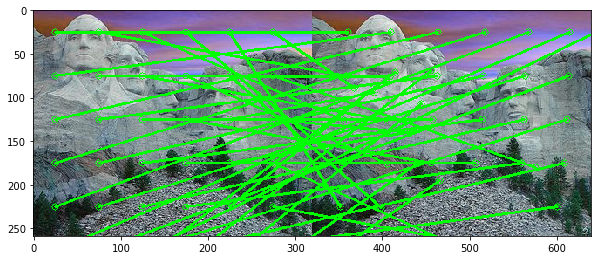

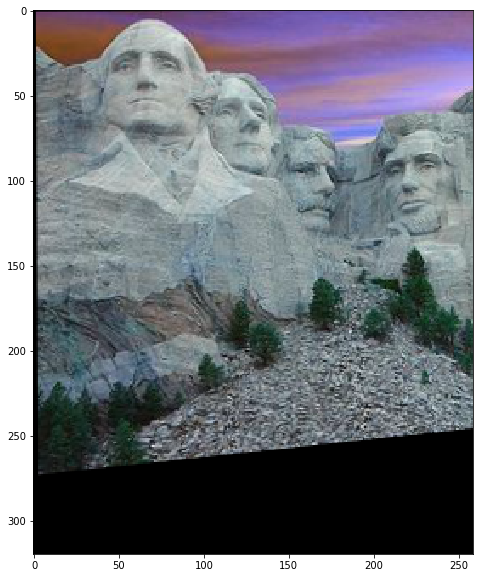

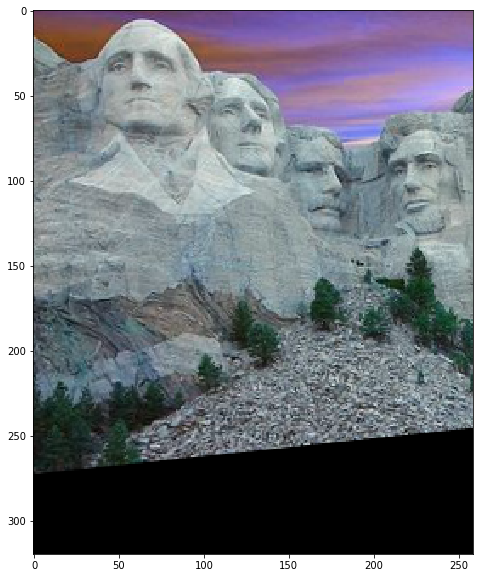

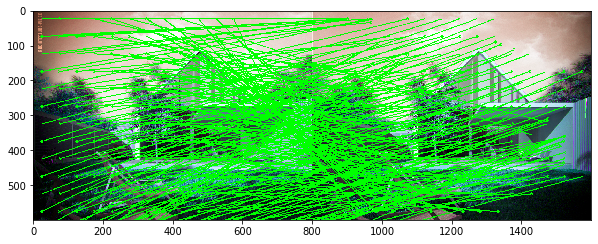

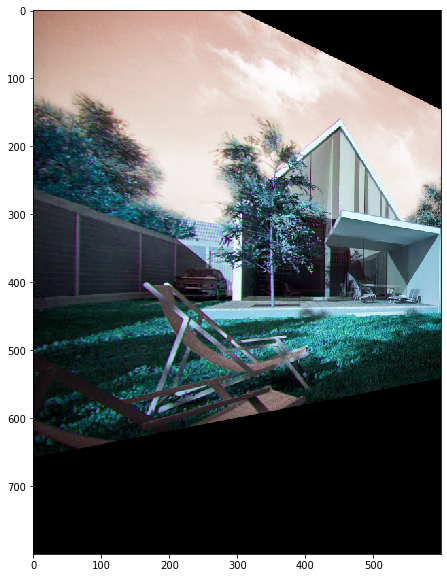

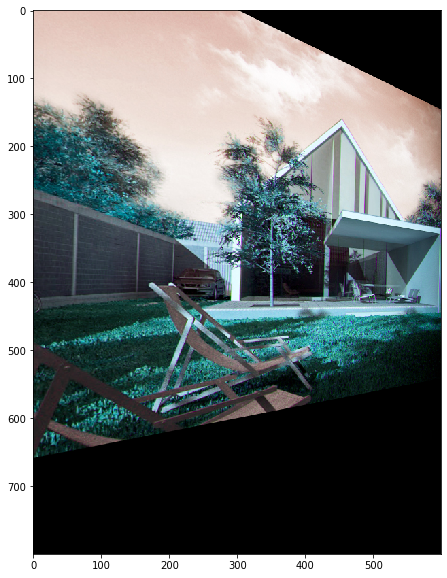

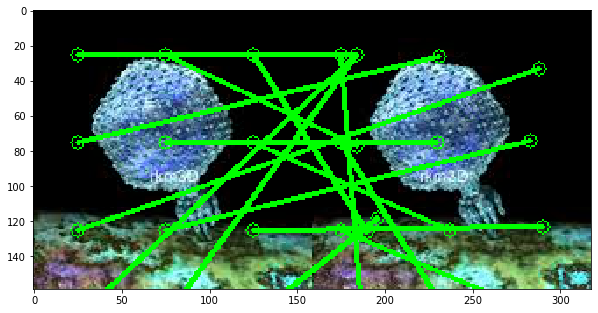

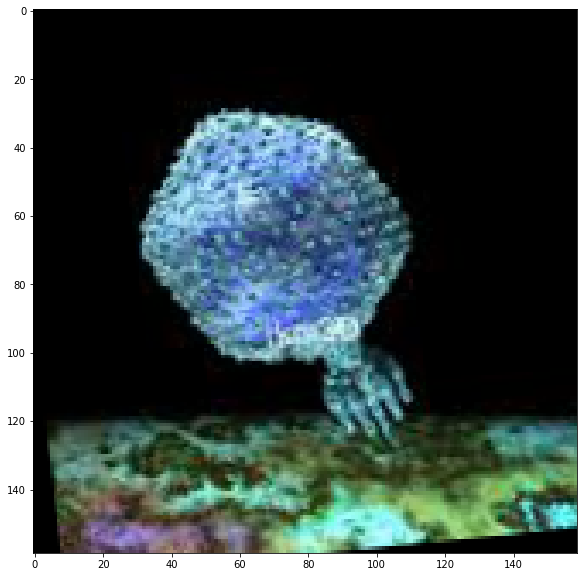

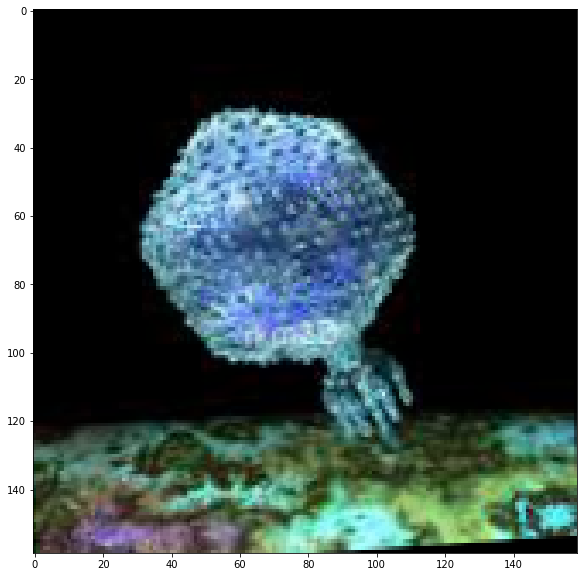

In [10]:
images = glob.glob('/content/drive/My Drive/computer_vision/assignments/assignment_2/images/stereo_images/*.jpg')
for fname in images:
    image = cv.imread(fname)
    width = image.shape[1]
    image_left, image_right = splitImage(image)
    image_output, pts1, pts2 = intensity_based_matching(image1=image_left, image2=image_right, window = 50)
    plt.imshow(image_output)
    plt.show()
    img1, img2 = rectify_images(image_left, image_right, np.asarray(pts1), np.asarray(pts2))
    plt.imshow(img1)
    plt.show()
    plt.imshow(img2)
    plt.show()

## Image Rectification

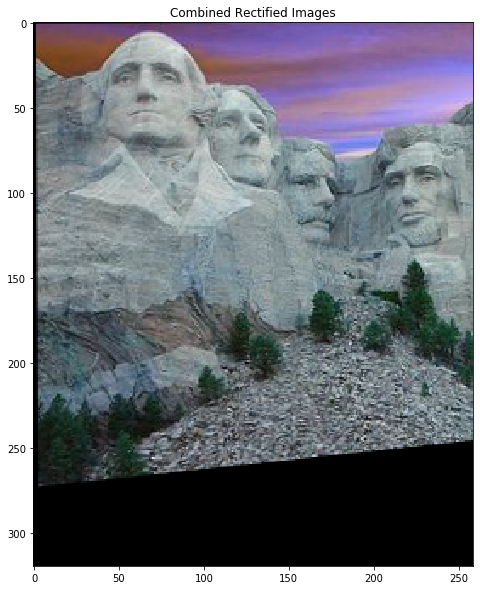

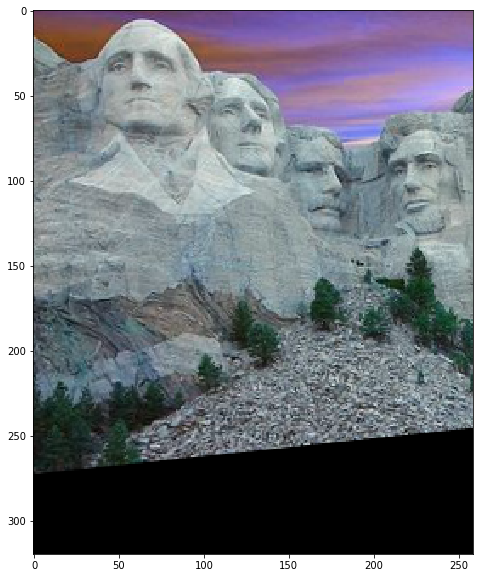

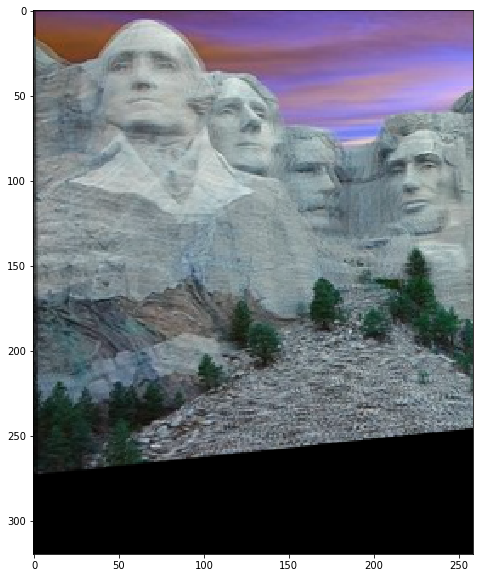

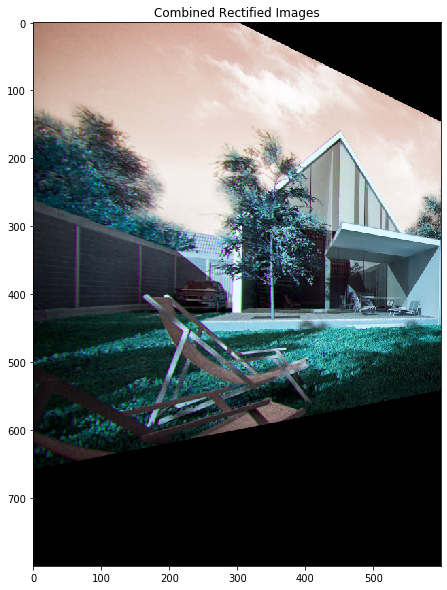

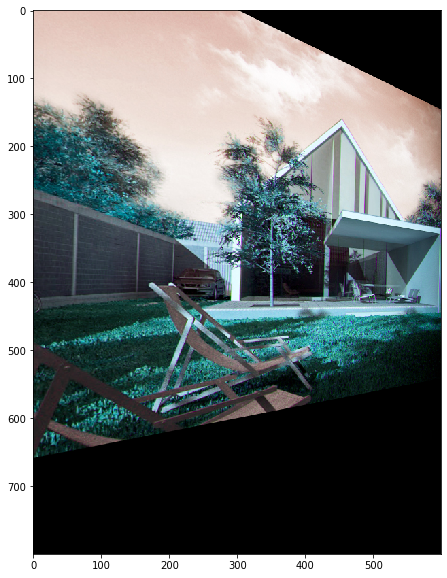

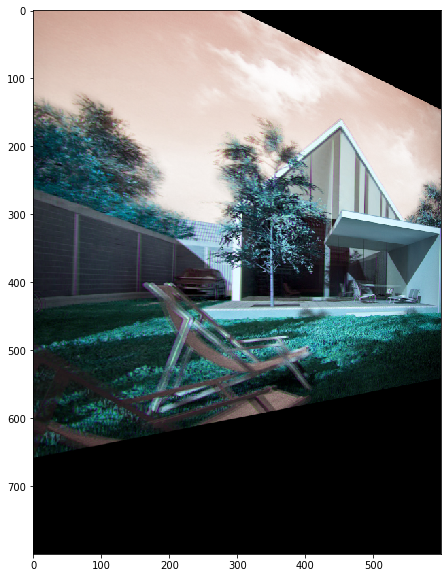

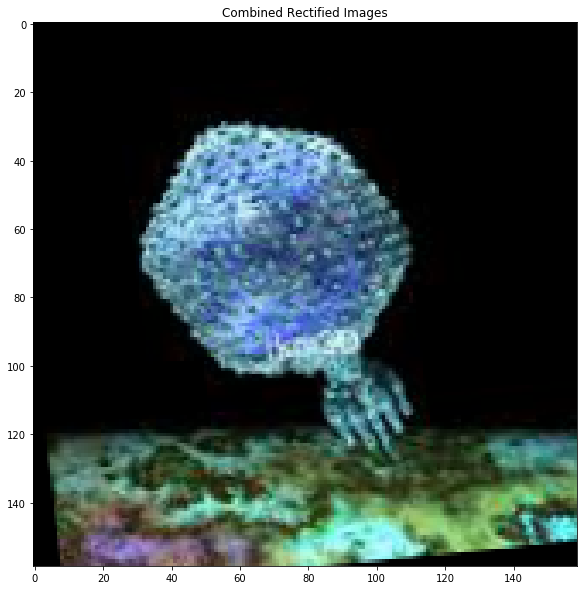

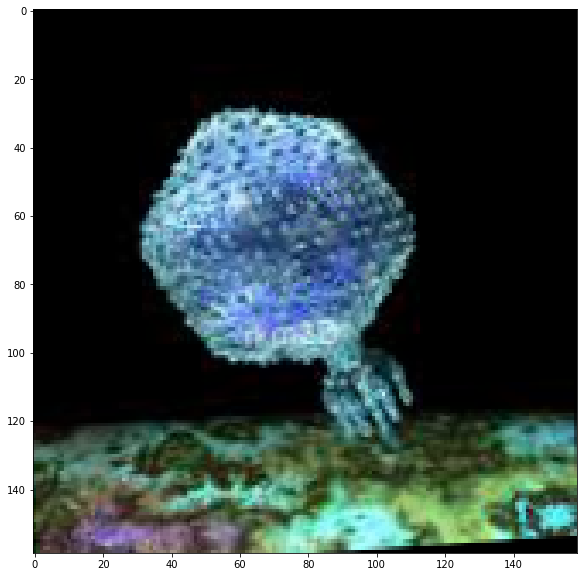

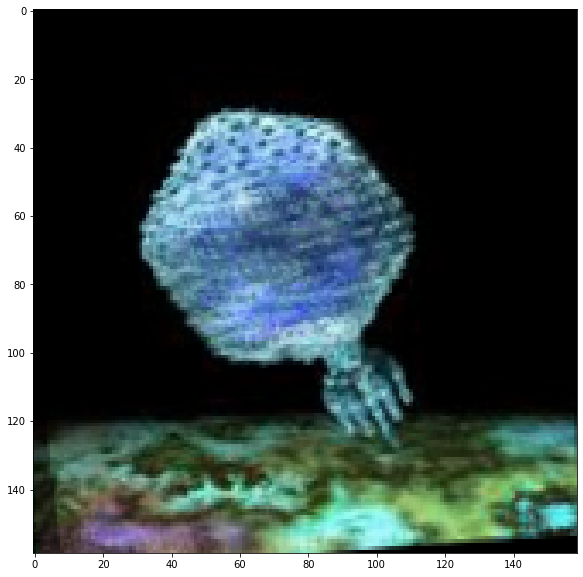

In [11]:
images = glob.glob('/content/drive/My Drive/computer_vision/assignments/assignment_2/images/stereo_images/*.jpg')
for fname in images:
    image = cv.imread(fname)
    width = image.shape[1]
    image_left, image_right = splitImage(image)
    cameraMatrix = np.eye(3)
    featurePoints1 = None
    featurePoints2 = None
    distortionParameters = []
    rectified1, rectified2 = rectify_with_sift(image_left, image_right)
    #cv.imwrite("rectified1.png", rectified1)
    #cv.imwrite("rectified2.png", rectified2)
    combined = normalize(np.float32(rectified1) + np.float32(rectified2))
    plt.figure()
    plt.title("Combined Rectified Images")
    plt.imshow(rectified1, cmap = "gray")
    plt.show()
    plt.imshow(rectified2, cmap = "gray")
    plt.show()
    plt.imshow(combined, cmap = "gray")
    plt.show()

## Greedy Matching

In [0]:
def greedyMatchTemplate(template1, img, row, window = 128):
    max_corr = -1e10
    best_col = 0
    for k in range(0, img.shape[1], window):
        template2 = img[row:row + window, k:k + window]
        t1, t2 = fixShape(template1, template2)
        corr = templateCorrelation(t1, t2)
        if (corr > max_corr):best_col = kmax_corr = corr
    center = (best_col + floor(window / 2),row + floor(window / 2))
    return center

def greedy_matching(img1, img2, window = 128):
    window = window
    full_img = np.concatenate((img1, img2), axis=1)
    points1=[]
    points2=[]
    for i in range(0, img1.shape[0], window):
        for j in range(0, img1.shape[1], window):
            template1 = img1[i:i + window, j:j + window]
            center1 = (j + floor(window / 2), i + floor(window / 2))
            points1.append(center1)
            center2 = greedyMatchTemplate(template1,img2,i,window)
            points2.append(center2)
            center2 = (center2[0] + floor(img1.shape[1]), center2[1])
            cv.circle(full_img,center1,4, (0, 255, 0),thickness=1,lineType=8,shift=0)
            cv.circle(full_img,(int(center2[0]), int(center2[1])),4, (0, 255, 0),thickness=1,lineType=8,shift=0)
            cv.line(full_img, center1, (int(center2[0]), int(center2[1])), (0, 255, 0), 2)
    #plt.imshow(full_img)
    #plt.show()
    return full_img, points1, points2

def computeGreedyMatch(img, distance=0.5, window=128):
    img1, img2 = splitImage(img)
    #img1, img2 = rectify_with_sift(img1, img2)
    image_output, pts1, pts2 = greedy_matching(img1, img2, window)
    plt.imshow(image_output)
    plt.show()
    img1, img2 = rectify_images(image_left, image_right, np.asarray(pts1), np.asarray(pts2))
    plt.imshow(img1)
    plt.show()
    plt.imshow(img2)
    plt.show()

def mean2(x):
    y = np.sum(x) / np.size(x)
    return y

def templateCorrelation(a, b):
    a = a - mean2(a)
    b = b - mean2(b)
    r = (a * b).sum() / np.sqrt((a * a).sum() * (b * b).sum())
    return r

def fixShape(template1, template2):
    template1 = template1.copy()
    template2 = template2.copy()
    if (template1.shape[1] > template2.shape[1]):
        template1 = template1[:, :template2.shape[1]]
    else:
        template2 = template2[:, :template1.shape[1]]
    return template1, template2

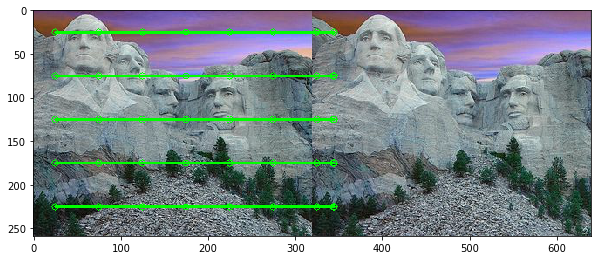

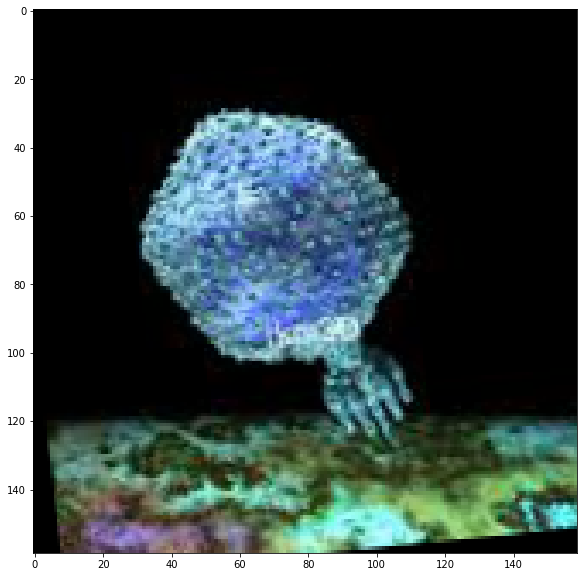

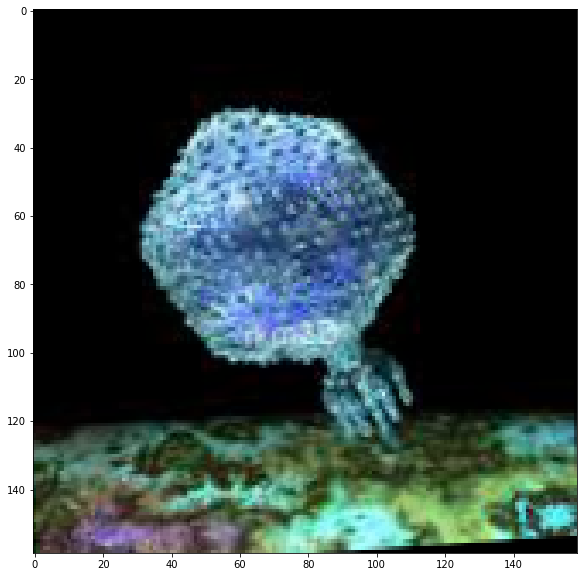

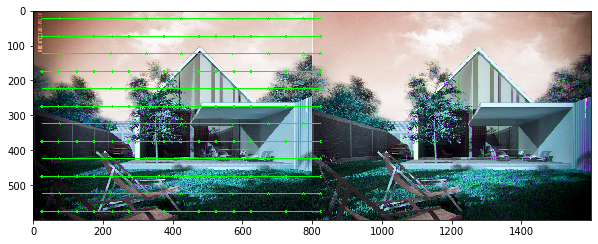

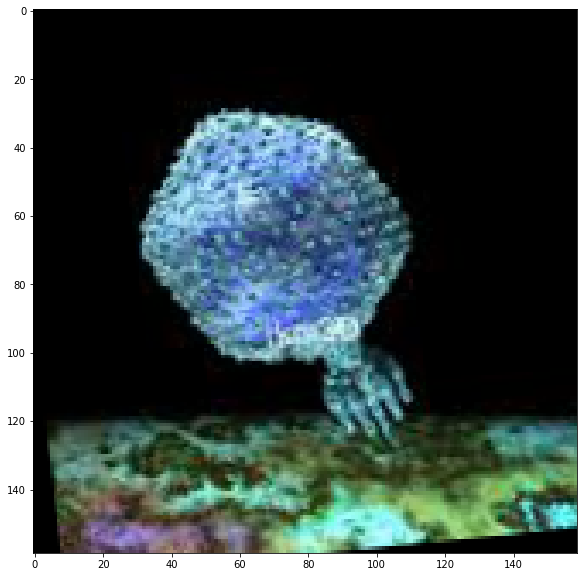

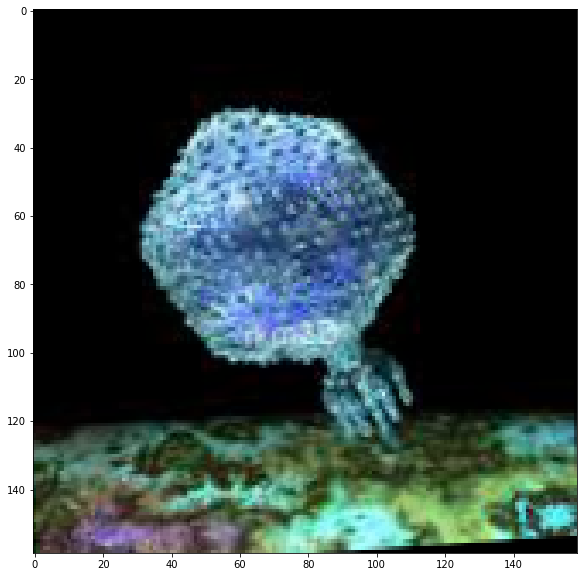

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


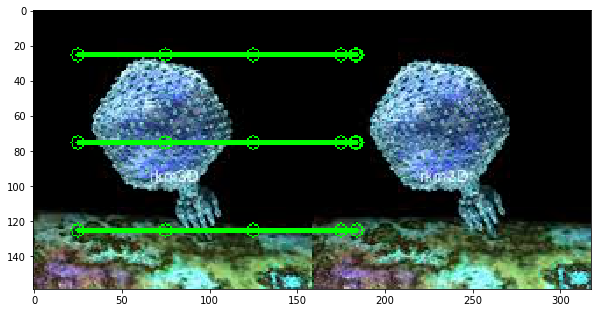

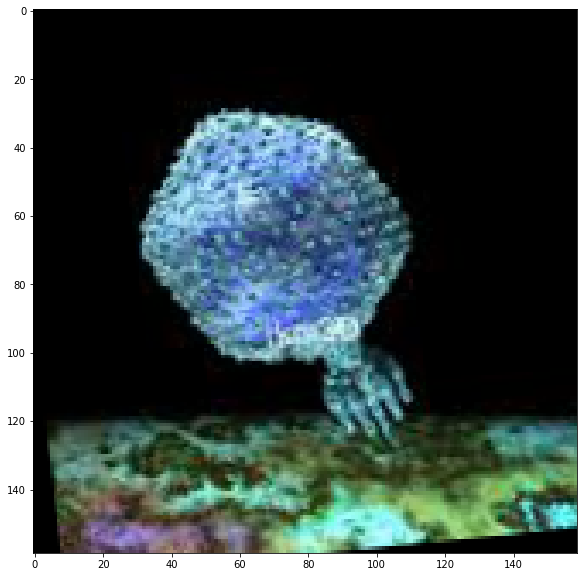

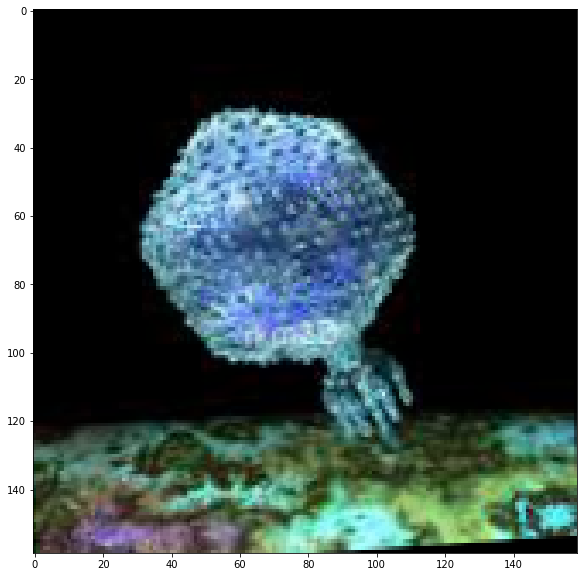

In [19]:
for fname in images:
    image = cv.imread(fname)
    computeGreedyMatch(image, window=50)

## Dynamic programming based matching

In [0]:
def computeDistance(image1, image2, window=128):
    distances = []
    for i in range(0, image1.shape[0], window):
        temp_dist_i = []
        for j in range(0, image1.shape[1], window):
            template1 = image1[i:i + window, j:j + window]
            temp_dist_j = []
            for k in range(0, image2.shape[1], window):
                template2 = image2[i:i + window, k:k + window]
                template1, template2 = fixShape(template1, template2)
                temp_dist_j.append(templateCorrelation(template1, template2))
            temp_dist_i.append(temp_dist_j)
        distances.append(temp_dist_i)
    return np.array(distances)

def DP_matching (image1, image2, window = 128):
    full_image = np.concatenate((image1, image2), axis=1)
    distances = computeDistance(image1, image2)
    points1 = []
    points2 = []
    for row in range(distances.shape[0]):
        cum_cost = np.zeros((distances.shape[2], distances.shape[1]))
        cum_cost[0, 0] = distances[row][0, 0]
        for i in range(1, distances.shape[1]):
            distances[row][0, i]
            cum_cost[0, i] = distances[row][0, i] + cum_cost[0, i - 1]
        for i in range(1, distances.shape[2]):
            cum_cost[i, 0] = distances[row][i, 0] + cum_cost[i - 1, 0]
        for i in range(1, distances.shape[2]):
            for j in range(1, distances.shape[1]):
                cum_cost[i, j] = min(
                    cum_cost[i - 1, j - 1], cum_cost[i - 1, j],
                    cum_cost[i, j - 1]) + distances[row][i, j]
                d = distances[row][i, j]
                path = [[distances.shape[1] - 1, distances.shape[2] - 1]]
                i = distances.shape[2] - 1
                j = distances.shape[1] - 1
                while i > 0 and j > 0:
                    if i == 0:
                        j = j - 1
                    elif j == 0:
                        i = i - 1
                    else:
                        if cum_cost[i - 1, j] + d == cum_cost[i, j]:
                            i = i - 1
                        elif cum_cost[i, j - 1] + d == cum_cost[i, j]:
                            j = j - 1
                        else:
                            i = i - 1
                            j = j - 1

                path.append([j, i])
            path.append([0, 0])
        for i in range(len(path)):
            c1 = (path[i][0] * window + int(window / 2),row * window + int(window / 2))
            points1.append(c1)
            c2 = (path[i][1] * window + int(window / 2),row * window + int(window / 2))
            points2.append(c2)
            c2 = (c2[0] + int(image1.shape[1]), c2[1])
            cv.circle(full_image,c1,8, (0, 255, 0),thickness=2,lineType=8,shift=0)
            cv.circle(full_image,c2,8, (0, 255, 0),thickness=2,lineType=8,shift=0)
            cv.line(full_image, c1, c2, (0, 255, 0), 2)
    plt.imshow(full_image)
    plt.show()
    return full_image, points1, points2

def computeDTWMatch(img, distance=0.75, window=128):
    img1, img2 = splitImage(img)
    #img1, img2 = rectify_with_sift(img1, img2)
    image_output, pts1, pts2 = DP_matching(img1, img2, window)
    plt.imshow(image_output)
    plt.show()
    img1, img2 = rectify_images(image_left, image_right, np.asarray(pts1), np.asarray(pts2))
    plt.imshow(img1)
    plt.show()
    plt.imshow(img2)
    plt.show()


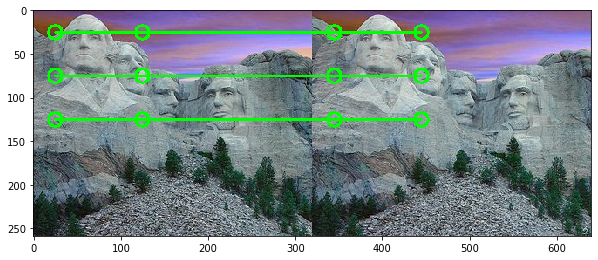

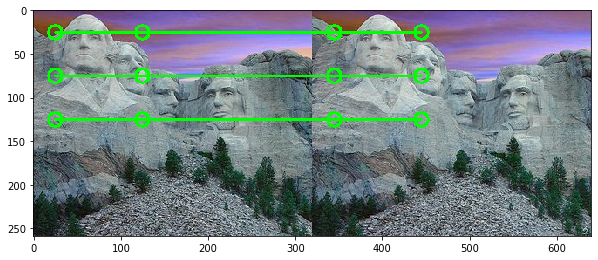

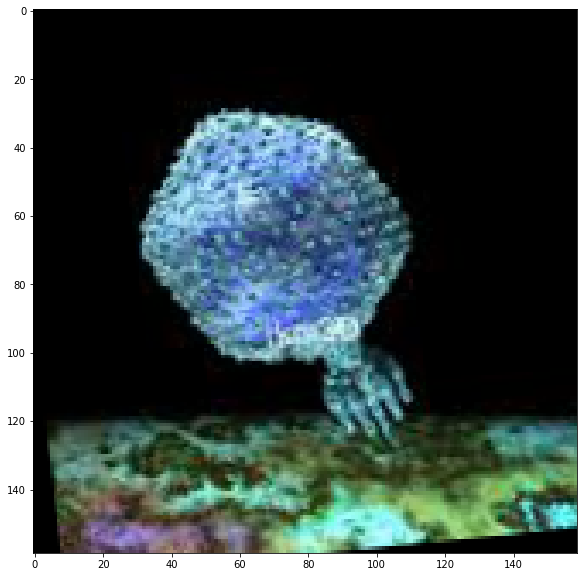

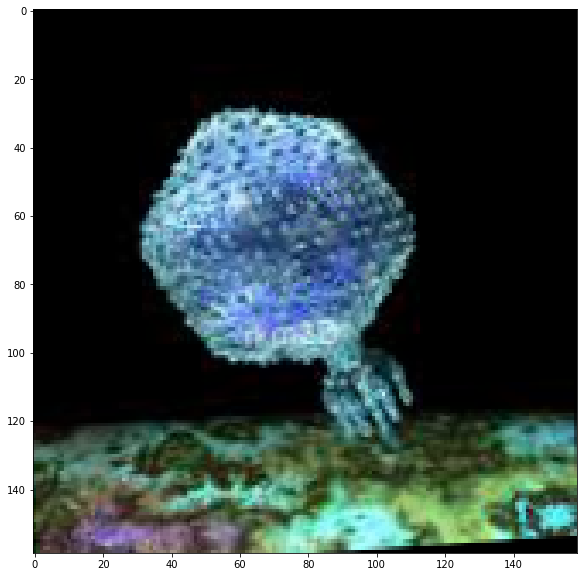

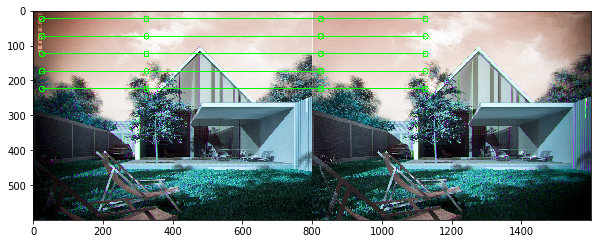

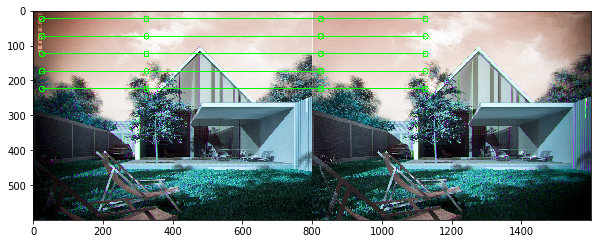

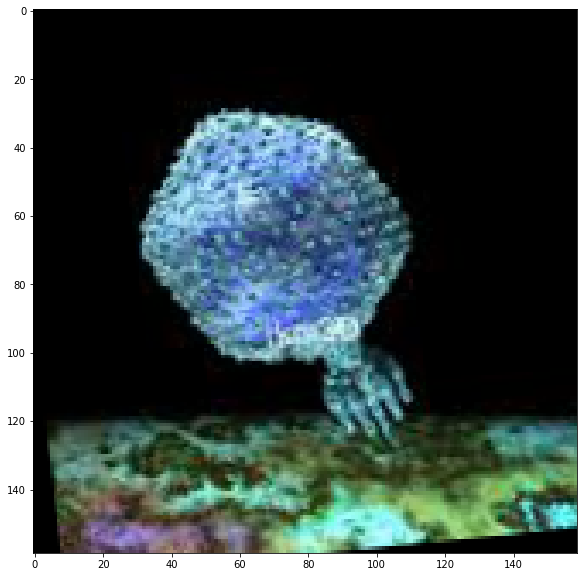

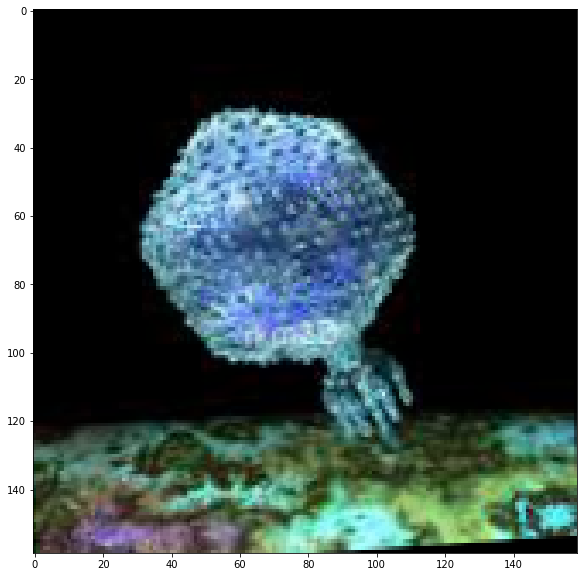

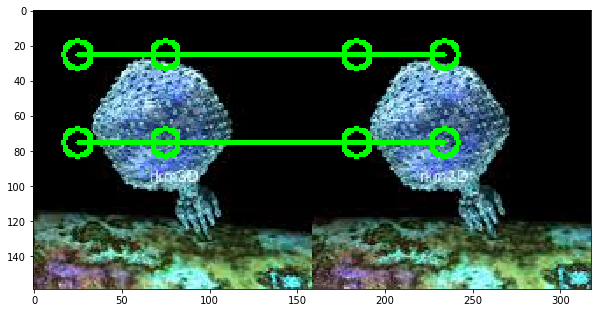

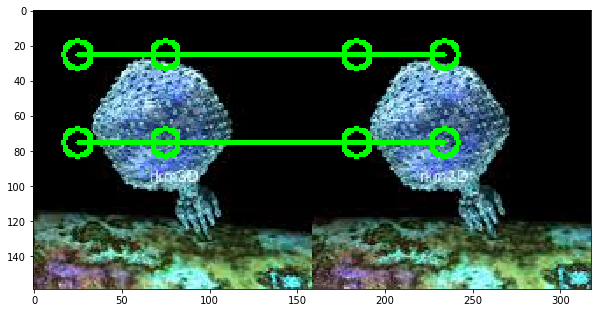

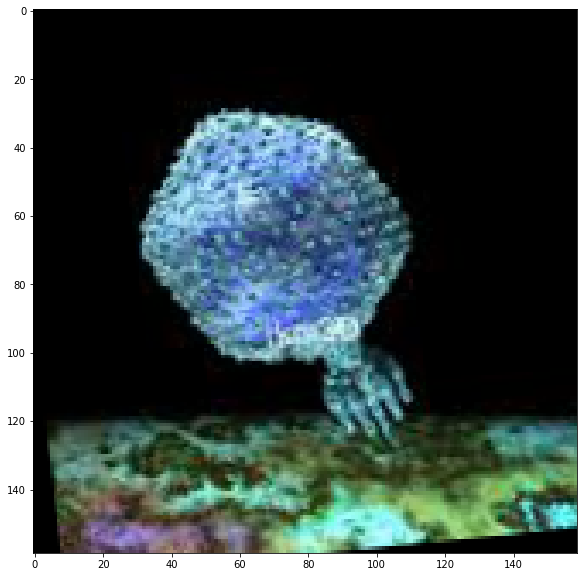

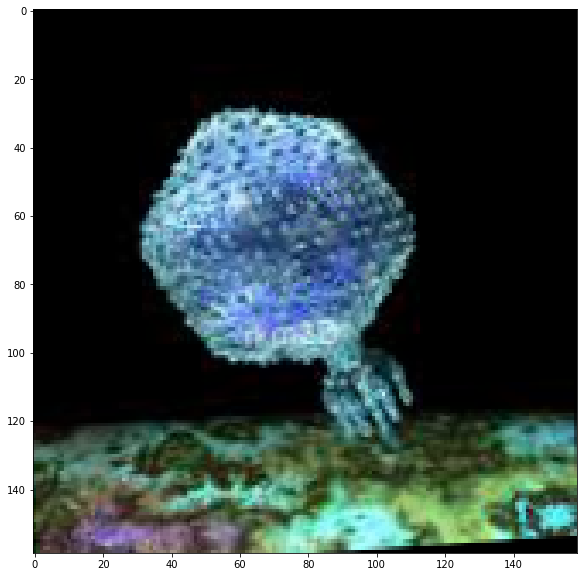

In [22]:
images = glob.glob('/content/drive/My Drive/computer_vision/assignments/assignment_2/images/stereo_images/*.jpg')
for fname in images:
    image = cv.imread(fname)
    computeDTWMatch(image, window = 50)